# Tutorial on "Graph Neural Networks from Scratch"

### Necessary imports

In [1]:
import networkx as nx
import matplotlib.pyplot as plt
from networkx.algorithms.community.modularity_max import greedy_modularity_communities

## 1. Loading the graph

We will use [Zachary's Karate Club]("https://en.wikipedia.org/wiki/Zachary%27s_karate_club").
 
This is one of the most popular benchmark datasets for problems related to community stucture and detection.
The dataset was proposed in ["An Information Flow Model for Conflict and Fission in Small Groups"](https://www.journals.uchicago.edu/doi/10.1086/jar.33.4.3629752) by Wayne W. Zachary.

By the legend, after an argument between the instructor('Mr. Hi') and the administrator('Officer'), the karate club broke into two.Therefore, each node is labeled either 'Mr. Hi' or 'Officer'.

In [2]:
G = nx.karate_club_graph()

In [7]:
number_of_nodes = G.number_of_nodes()
number_of_edges = G.number_of_edges()
print(f"G is undirected graph with {number_of_nodes} and {number_of_edges} edges.")

G is undirected graph with 34 and 78 edges.


In [11]:
def get_binary_labels(graph):
    labels_dict = nx.get_node_attributes(graph,'club')
    labels = [0 if v == 'Mr. Hi' else 1 for _, v in labels_dict.items()]
    return labels

In [17]:
def draw_graph(graph):
    binary_labels = get_binary_labels(graph)
    nx.draw(G, node_color=binary_labels)

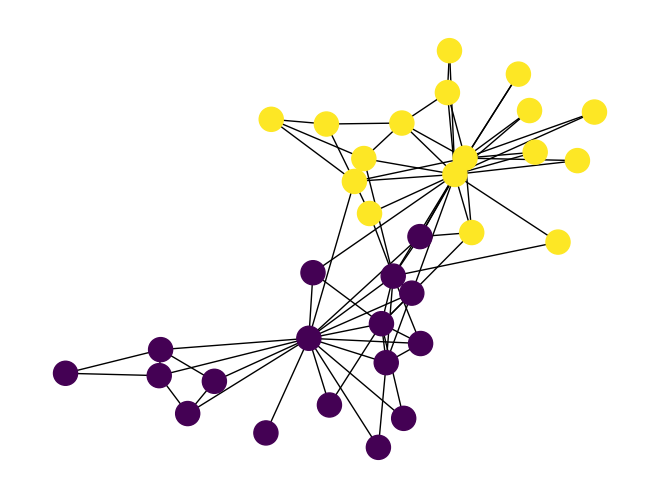

In [18]:
draw_graph(G)

So this was the visual representation of the graph. Now let us get **adjacency matrix** for this graph.

**Adjacency matrix** is another form of graph representation which is more useful for computational purposes. 
[i,j] elemnt of this matrix is zero if there is no connection between i-th and j-th nodes, else we put some value *(1 for example)*. See more information [here](https://en.wikipedia.org/wiki/Adjacency_matrix).

In [20]:
A = nx.adjacency_matrix(G)
A

<34x34 sparse array of type '<class 'numpy.int64'>'
	with 156 stored elements in Compressed Sparse Row format>

The result is a sparse matrix because we have only 78 connections out of 561 possible connections in the graph. Let us convert it to regular numpy array.

In [22]:
A_numpy = A.toarray()
A_numpy

array([[0, 4, 5, ..., 2, 0, 0],
       [4, 0, 6, ..., 0, 0, 0],
       [5, 6, 0, ..., 0, 2, 0],
       ...,
       [2, 0, 0, ..., 0, 4, 4],
       [0, 0, 2, ..., 4, 0, 5],
       [0, 0, 0, ..., 4, 5, 0]])

## 2. Factorizing the adjacency matrix

Why do we need to factorize the adjacency matrix? Something with message passing, video with description: [https://www.youtube.com/watch?v=ijmxpItkRjc]()

After that step is done, we can move on to model...

## 3. Graph Convolution Layer